In [1]:
import tessreduce as tr
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

import lightkurve as lk
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.coordinates import  FK4
coords = ["02:22:22.6225216707 +78:54:37.781867572"]
c = SkyCoord(coords, frame=FK4, unit=(u.hourangle, u.deg))
#tpf = lk.search_tesscut("02 22 22.6225216707 +78 54 37.781867572", sector=18).download(cutout_size = 90)
tpf = tr.Get_TESS(c.ra.degree,c.dec.degree,90,18)
aper_b18 = np.zeros(tpf.shape[1:], dtype=bool)
aper_b18[44:48, 44:47] = True
dict18 = tr.Quick_reduce(tpf, aper=aper_b18, bin_size=0, all_output=True)

made reference
made source mask
calculating background
background subtracted
calculating centroids
images shifted
made light curve


In [2]:
flux = dict18['flux']
tab = tr.Unified_catalog(tpf,magnitude_limit=18)
col = tab.col.values + .5
row = tab.row.values + .5
pos = np.array([col,row]).T

median = np.nanmedian(flux,axis=0)

index, med_cut, stamps = tr.Isolated_stars(pos,tab['tmag'].values,flux,median,Distance=3)

isolated = tab.iloc[index]
ps1ind = np.isfinite(isolated['imag'].values)

isolated = isolated.iloc[ps1ind]
med_cut = med_cut[ps1ind]
stamps = stamps[ps1ind]
if len(isolated) < 10:
    raise Warning('Only {} sources used for zerpoint calculation. Errors may be larger than reported'.format(len(isolated)))
isolc = np.nansum(stamps,axis=(2,3))
ind = (np.nanmedian(isolc,axis=1) > 100) & (np.nanmedian(isolc,axis=1)*.1 >= np.nanstd(isolc,axis=1)) & (np.nanmedian(isolc,axis=1) < 1000)
isolc = isolc[ind]

In [ ]:
len(isolc)

In [ ]:
isolc[0]

<IPython.core.display.Javascript object>


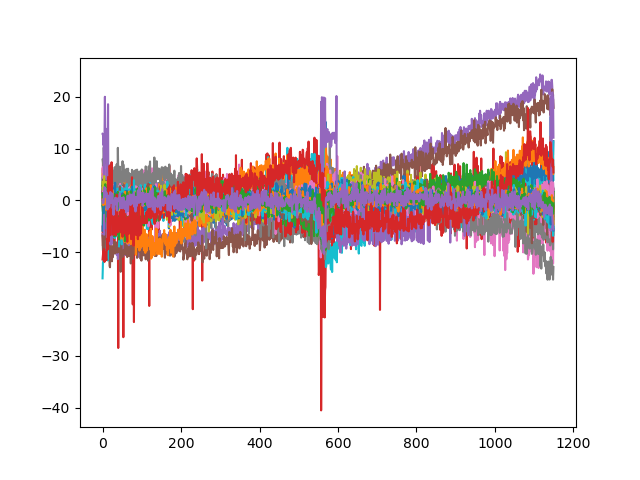

In [178]:
plt.figure()
for i in range(len(isolc)):
    plt.plot(isolc[i]-np.nanmedian(isolc[i]))
#plt.yscale('log')
#plt.ylim(-100,300)

In [ ]:
err = np.nanstd(isolc-np.nanmedian(isolc[:,~higherr],axis=1)[:,np.newaxis],axis=0)

In [11]:
from astropy.stats import sigma_clip

In [209]:
err = np.nanstd(isolc-np.nanmedian(isolc,axis=1)[:,np.newaxis],axis=0)
higherr = sigma_clip(err,sigma=2).mask
ind = (np.nanmedian(isolc[:,~higherr],axis=1) > 100) & (np.nanmedian(isolc[:,~higherr],axis=1)*.1 >= np.nanstd(isolc[:,~higherr],axis=1)) #& (np.nanmedian(isolc,axis=1) < 1000)

In [210]:
len(err)

1103

<IPython.core.display.Javascript object>


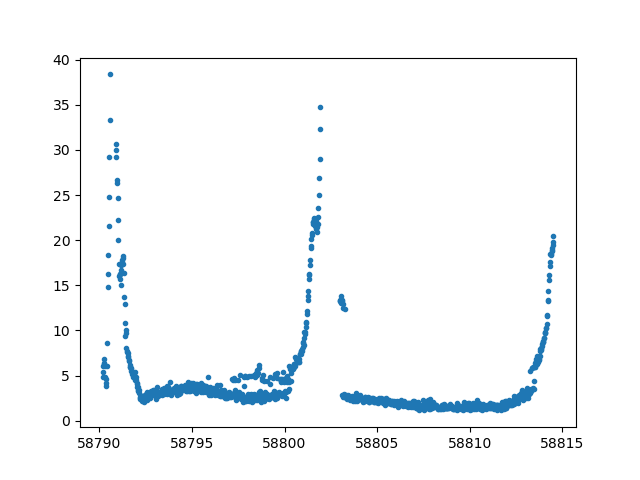

[]

In [211]:
lc = dict18['lc']
plt.figure()
plt.plot(lc[0],err,'.')
#plt.plot(lc[0][~test],err[~test],'.')
plt.plot()

<IPython.core.display.Javascript object>


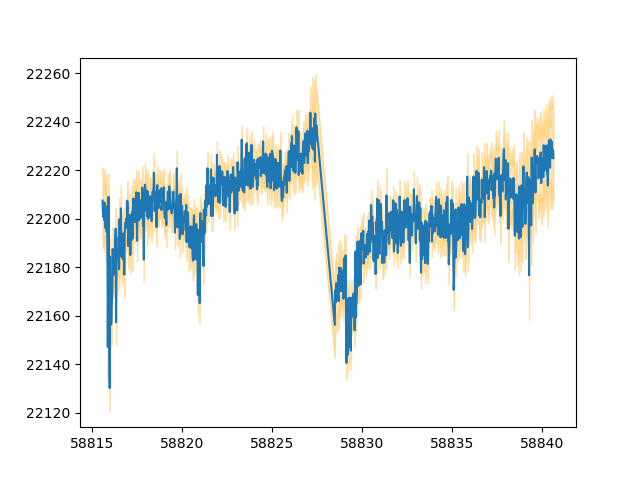

In [181]:
lc = dict18['lc']
plt.figure()
plt.fill_between(lc[0],lc[1]-3*err,lc[1]+3*err,alpha=.3,color='orange')
plt.plot(lc[0],lc[1])


In [20]:
lc = dict18['lc']
med = np.nanmedian(lc[1])
std = np.nanstd(lc[1])
mask = (lc[1]-3*err > med + 3*std)

In [30]:
def sig_err(data,err=None,sig=3,sig_up=None,sig_low=None,maxiter=10):
    clipped = data.copy()
    c_err = err.copy()
    ind = np.arange(0,len(data))
    breaker = 0
    if err is not None:
        for i in range(maxiter):
            nonan = np.isfinite(clipped)
            med = np.average(clipped[nonan],weights=1/c_err[nonan])
            #med = np.nanmedian(clipped)
            std = np.nanstd(clipped)
            mask = (clipped-1*err > med + 3*std) #| (clipped+1*err < med - 3*std)
            clipped[mask] = np.nan
            c_err[mask] = np.nan
            if ~mask.any():
                break

        mask = np.isnan(clipped)
    else:
        mask = sigma_clip(data).mask
    return mask

In [22]:
mask = sig_err(lc[1],err)

In [23]:
mask

array([False, False, False, ..., False, False, False])

In [28]:
p = find_peaks(lc[1],distance=10)[0]

<IPython.core.display.Javascript object>


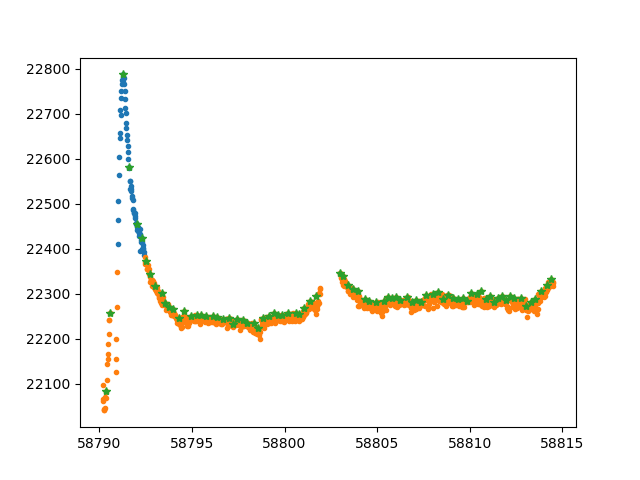

In [29]:
plt.figure()
#plt.fill_between(lc[0],lc[1]-3*err,lc[1]+3*err,alpha=.3,color='orange')
plt.plot(lc[0][mask],lc[1][mask],'.')
plt.plot(lc[0][~mask],lc[1][~mask],'.')
plt.plot(lc[0][p],lc[1][p],'*')

In [31]:
from scipy.signal import find_peaks
from scipy.signal import savgol_filter

In [42]:
full = (~mask) & (~higherr)
ll = savgol_filter(lc[1][full],31,2)
grad = np.gradient(lc[1])
sg = savgol_filter(grad,11,2)
sg2 = np.gradient(ll)
med = np.nanmedian(sg2)
std = np.nanstd(sg2)

<IPython.core.display.Javascript object>


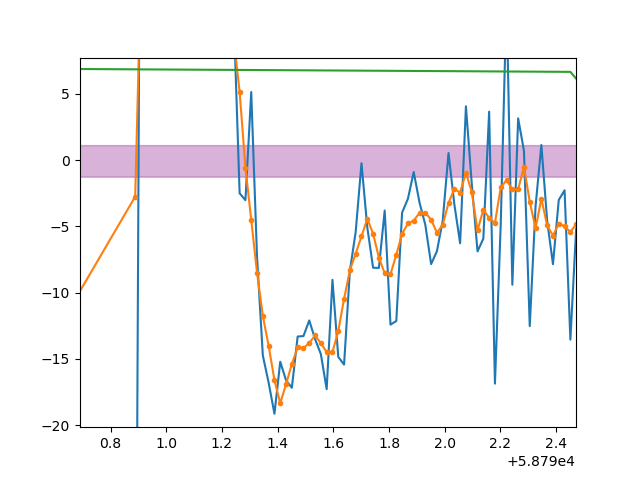

In [40]:
plt.figure()
plt.plot(lc[0],grad)
plt.plot(lc[0],sg,'.-')
plt.plot(lc[0][full],sg2)
plt.fill_between(lc[0],med+std,med-std,alpha=.3,color='purple')

In [56]:
ll = savgol_filter(lc[1],31,2)
grad = np.gradient(lc[1])
sg = np.gradient(ll[(~higherr) & (~mask)])
sg = savgol_filter(grad,11,2)
med = np.nanmedian(sg[full])
std = np.nanstd(sg[full])

<IPython.core.display.Javascript object>


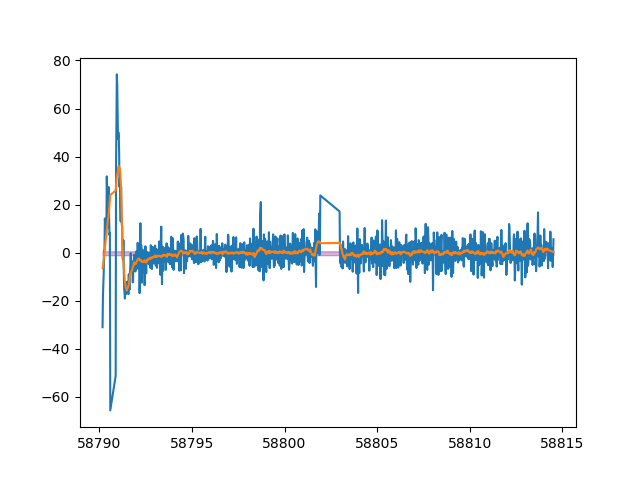

IndexError: index 76 is out of bounds for axis 0 with size 70

In [57]:
plt.figure()
plt.plot(lc[0],grad)
plt.plot(lc[0],np.gradient(ll))
plt.fill_between(lc[0],med+.5*std,med-.5*std,alpha=.3,color='purple')
plt.plot(lc[0][mask][p],grad[mask][p],'*')

In [ ]:
from scipy.signal import peak_prominences

In [ ]:
peak_prominences(lc[1],p)

In [ ]:
t = find_peaks(ll,height=100)[0]

In [58]:
a = ((sg < med-std) & full)

In [55]:
sg

array([-30.19204491, -20.83604037, -12.70457305, ...,   0.44703923,
         0.67540354,   0.95759728])

<IPython.core.display.Javascript object>


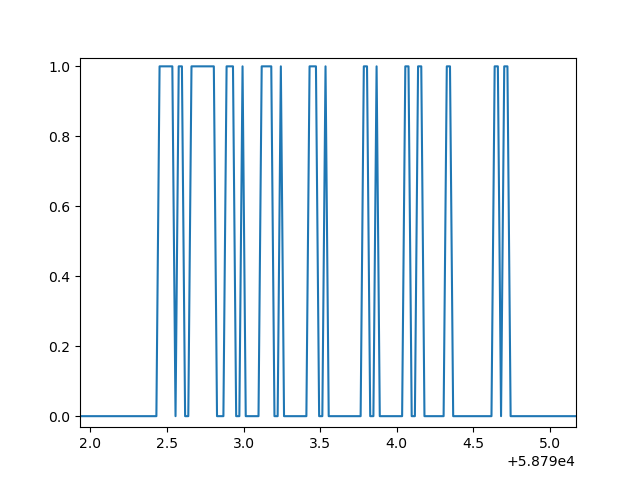

In [59]:
plt.figure()
plt.plot(lc[0],a)

In [ ]:
peak_prominences(lc[1][(~higherr) & (~mask)],t)`

In [60]:
p

array([   9,   20,   39,   56,   76,   88,   99,  110,  124,  140,  150,
        160,  170,  185,  196,  215,  231,  241,  253,  273,  283,  297,
        313,  323,  333,  350,  361,  378,  389,  401,  417,  428,  439,
        451,  466,  485,  495,  506,  523,  537,  550,  560,  573,  586,
        597,  616,  626,  645,  664,  676,  687,  697,  707,  724,  737,
        748,  761,  772,  790,  804,  816,  829,  842,  855,  869,  879,
        889,  906,  916,  927,  939,  949,  959,  969,  980,  990, 1001,
       1019, 1031, 1043, 1054, 1071, 1085, 1095])

In [61]:
mask

array([False, False, False, ..., False, False, False])

In [62]:
from scipy import ndimage

In [63]:
def find_clusters(array):
    clustered = np.empty_like(array)
    unique_vals = np.unique(array)
    cluster_count = 0
    for val in unique_vals:
        labelling, label_count = ndimage.label(array == val)
        for k in range(1, label_count + 1):
            clustered[labelling == k] = cluster_count
            cluster_count += 1
    return clustered, cluster_count


In [64]:
find_clusters(mask*1)

(array([0, 0, 0, ..., 1, 1, 1]), 3)

In [66]:
from scipy.ndimage.filters import convolve

In [73]:
def Identify_masks(Obj):
    """
    Uses an iterrative process to find spacially seperated masks in the object mask.
    """
    objsub = np.copy(Obj)
    Objmasks = []

    mask1 = np.zeros((Obj.shape))
    if np.nansum(objsub) > 0:
        mask1[np.where(objsub==1)[0]] = 1
        print(mask1)
        while np.nansum(objsub) > 0:
            print(np.nansum(objsub))
            conv = ((convolve(mask1*1,np.ones(3),mode='constant', cval=0.0)) > 0)*1.0
            objsub = objsub - mask1
            objsub[objsub < 0] = 0

            if np.nansum(conv*objsub) > 0:

                mask1 = mask1 + (conv * objsub)
                mask1 = (mask1 > 0)*1
            else:

                Objmasks.append(mask1)
                mask1 = np.zeros((Obj.shape))
                if np.nansum(objsub) > 0:
                    mask1[np.where(objsub==1)[0]] = 1
    return Objmasks

[0. 0. 0. ... 0. 0. 0.]
70


In [121]:
thing = Identify_masks(mask*1)
med = np.nanmedian(lc[1][~mask & ~higherr])
std = np.nanstd(lc[1][~mask & ~higherr])

for t in thing:
    print(np.where(t)[0])
    m = np.argmax(lc[1]*t)
    sig = (lc[1][m] - med) / std
    t[int(m-sig):int(m+7*sig)] = 1
    t = t > 0
    print(np.where(t)[0])

[0. 0. 0. ... 0. 0. 0.]
70
[26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73
 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]
[ 20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 166]


<IPython.core.display.Javascript object>


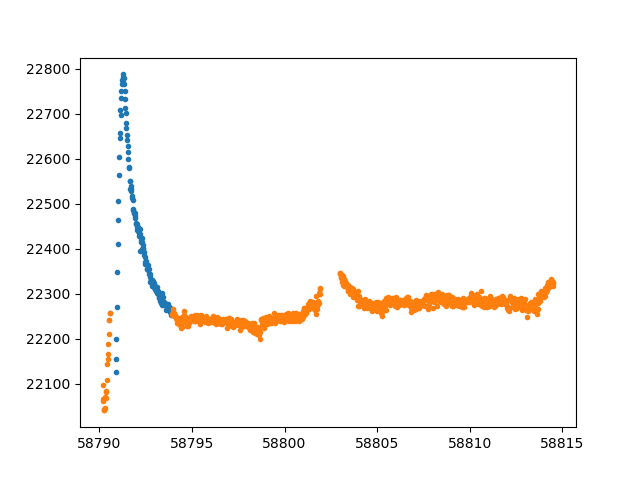

In [122]:
plt.figure()
#plt.fill_between(lc[0],lc[1]-3*err,lc[1]+3*err,alpha=.3,color='orange')
plt.plot(lc[0][t],lc[1][t],'.')
plt.plot(lc[0][~t],lc[1][~t],'.')

In [137]:
from scipy.interpolate import interp1d

In [228]:
def sig_err(data,err=None,sig=3,maxiter=10):
    if sig is None:
        sig = 3
    clipped = data.copy()
    ind = np.arange(0,len(data))
    breaker = 0
    if err is not None:
        for i in range(maxiter):
            nonan = np.isfinite(clipped)
            med = np.average(clipped[nonan],weights=1/err[nonan])
            #med = np.nanmedian(clipped)
            std = np.nanstd(clipped)
            mask = (clipped-1*err > med + 3*std) #| (clipped+1*err < med - 3*std)
            clipped[mask] = np.nan
            if ~mask.any():
                break

        mask = np.isnan(clipped)
    else:
        mask = sigma_clip(data).mask
    return mask


def Identify_masks(Obj):
    """
    Uses an iterrative process to find spacially seperated masks in the object mask.
    """
    objsub = np.copy(Obj)
    Objmasks = []

    mask1 = np.zeros((Obj.shape))
    if np.nansum(objsub) > 0:
        mask1[np.where(objsub==1)[0]] = 1
        print(mask1)
        while np.nansum(objsub) > 0:
            print(np.nansum(objsub))
            conv = ((convolve(mask1*1,np.ones(3),mode='constant', cval=0.0)) > 0)*1.0
            objsub = objsub - mask1
            objsub[objsub < 0] = 0

            if np.nansum(conv*objsub) > 0:

                mask1 = mask1 + (conv * objsub)
                mask1 = (mask1 > 0)*1
            else:

                Objmasks.append(mask1)
                mask1 = np.zeros((Obj.shape))
                if np.nansum(objsub) > 0:
                    mask1[np.where(objsub==1)[0]] = 1
    return Objmasks

def auto_tail(lc,mask,err = None):
    if err is not None:
        higherr = sigma_clip(err,sigma=2).mask
    else:
        higherr = False
    masks = Identify_masks(mask*1)
    med = np.nanmedian(lc[1][~mask & ~higherr])
    std = np.nanstd(lc[1][~mask & ~higherr])

    if lc.shape[1] > 4000:
        tail_length = 70
        start_length = 10
    else:
        tail_length = 7
        start_length = 1
            
    for i in range(len(masks)):
        m = np.argmax(lc[1]*masks[i])
        sig = (lc[1][m] - med) / std
        print(sig)
        if sig > 20:
            sig =20
        masks[i][int(m-sig*start_length):int(m+tail_length*sig)] = 1
        masks[i] = masks[i] > 0
    summed = np.nansum(masks*1,axis=0)
    mask = summed > 0 
    return ~mask
        
def Multiple_day_breaks(lc):
    """
    If the TESS data has a section of data isolated by at least a day either side,
    it is likely poor data. Such regions are identified and removed.
    
    Inputs:
    -------
    Flux - 3d array
    Time - 1d array
    
    Output:
    -------
    removed_flux - 3d array
    """
    ind = np.where(~np.isnan(lc[1]))[0]
    breaks = np.array([np.where(np.diff(lc[0][ind]) > .5)[0] +1])
    breaks = np.insert(breaks,0,0)
    breaks = np.append(breaks,len(lc[0]))
    return breaks

def Remove_stellar_variability(lc,err=None,variable=False,sig = None, sig_up = 3, sig_low = 10, tail_length='auto'):
    """
    Removes all long term stellar variability, while preserving flares. Input a light curve 
    with shape (2,n) and it should work!

    Parameters
    ----------
    lc : array
        lightcurve with the shape of (2,n), where the first index is time and the second is 
        flux.
    sig_up : float
        upper sigma clip value 
    sig_low : float
        lower sigma clip value
    tail_length : str OR int
        option for setting the buffer zone of points after the peak. If it is 'auto' it 
        will be determined through functions, but if its an int then it will take the given 
        value as the buffer tail length for fine tuning.

    Outputs
    -------
    trends : array
        the stellar trends, subtract this from your input lc
    """
    # Make a smoothing value with a significant portion of the total 
    trends = np.zeros(lc.shape[1])
    break_inds = Multiple_day_breaks(lc)
    print(break_inds)
    
    if variable:
        size = int(lc.shape[1] * 0.04)
        if size / 2 == int(size/2): size += 1
        smooth = savgol_filter(lc[1,:],size,3)
        mask = sig_err(lc[1]-smooth,err,sig=sig)
        #sigma_clip(lc[1]-smooth,sigma=sig,sigma_upper=sig_up,
        #                    sigma_lower=sig_low,masked=True).mask
    else:
        mask = sig_err(lc[1],err,sig=sig)
        
    ind = np.where(mask)[0]
    masked = lc.copy()
    # Mask out all peaks, with a lead in of 5 frames and tail of 100 to account for decay
    # todo: use findpeaks to get height estimates and change the buffers accordingly
    if type(tail_length) == str:
        if tail_length == 'auto':
            print('auto')
            m = auto_tail(lc,mask,err)
            masked[:,~m] = np.nan
            plt.figure()
            plt.plot(masked[0],masked[1],'.')
        else:
            if lc.shape[1] > 4000:
                tail_length = 100
                start_length = 1
            else:
                tail_length = 10
            for i in ind:
                masked[:,i-5:i+tail_length] = np.nan
    else:
        tail_length = int(tail_length)
        if type(tail_length) != int:
            raise ValueError("tail_length must be either 'auto' or an integer")
        for i in ind:
            masked[:,i-5:i+tail_length] = np.nan
    print(masked[1])
    
    ## Hack solution doesnt need to worry about interpolation. Assumes that stellar variability 
    ## is largely continuous over the missing data regions.
    #f1 = interp1d(lc[0,finite], lc[1,finite], kind='linear',fill_value='extrapolate')
    #interp = f1(lc[0,:])

    # Smooth the remaining data, assuming its effectively a continuous data set (no gaps)
    size = int(lc.shape[1] * 0.005)
    if size / 2 == int(size/2): 
        size += 1
    for i in range(len(break_inds)-1):
        section = lc[:,break_inds[i]:break_inds[i+1]]
        finite = np.isfinite(masked[1,break_inds[i]:break_inds[i+1]])
        smooth = savgol_filter(section[1,finite],size,1)
        plt.plot(section[0,finite],smooth)
        # interpolate the smoothed data over the missing time values
        f1 = interp1d(section[0,finite], smooth, kind='linear',fill_value='extrapolate')
        trends[break_inds[i]:break_inds[i+1]] = f1(section[0])
    # huzzah, we now have a trend that should remove stellar variability, excluding flares.
    return trends 

[   0  550 1103]
auto
[0. 0. 0. ... 0. 0. 0.]
70
18.425559026690582


<IPython.core.display.Javascript object>


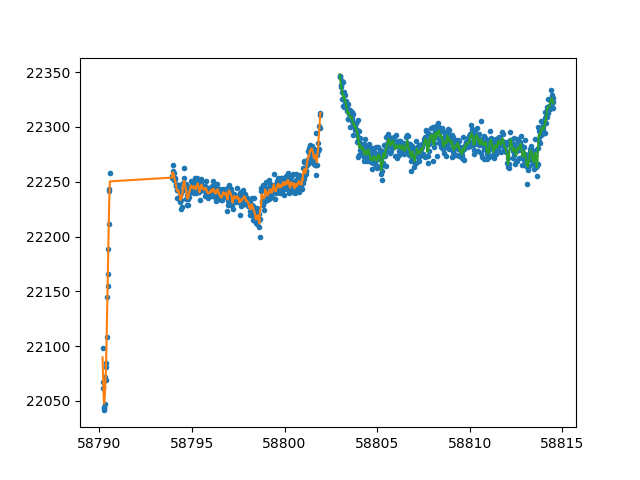

[22098.62625835 22067.54543259 22061.80344914 ... 22326.02582662
 22317.53779022 22323.08556131]


In [229]:
test = Remove_stellar_variability(lc,err)

In [222]:
lc.shape

(2, 1103)

<IPython.core.display.Javascript object>


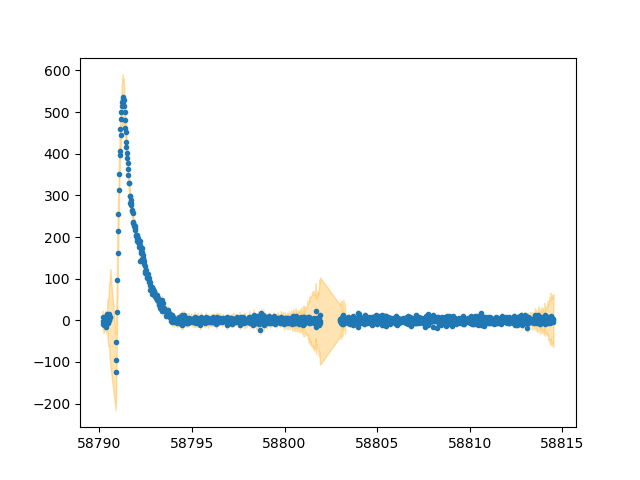

In [223]:
plt.figure()
plt.plot(lc[0],lc[1]-test,'.')
plt.fill_between(lc[0],lc[1]-3*err-test,lc[1]+3*err-test,alpha=.3,color='orange')

In [144]:
print(test[1])

22076.197085943513


In [149]:
test.shape

(1103,)